In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from transformers import Trainer, TrainingArguments
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU instead.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Load Data
folder_path_train = "data/cleaned/train"
folder_path_test = "data/cleaned/test"
names = ["Facebook", "Reddit", "Twitter", "Youtube"]
dfs_train = {n: pd.read_csv(os.path.join(folder_path_train, f"{n.lower()}_train.csv")) for n in names}
dfs_test = {n: pd.read_csv(os.path.join(folder_path_test, f"{n.lower()}_test.csv")) for n in names}


2024-07-03 10:21:26.766050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 10:21:26.999925: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 10:21:27.841658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-07-03 10:21:27.841803

Using GPU: NVIDIA A10


In [2]:
def train_and_evaluate(train_name, test_names, model_name, model_class, tokenizer_class, save_path):
    df_train = dfs_train[train_name]
    df_train['label'] = df_train['label'].astype(int)
    train_dataset = Dataset.from_pandas(df_train)

    tokenizer = tokenizer_class.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_train = tokenized_train.remove_columns(['text'])
    tokenized_train.set_format('torch')

    train_loader = DataLoader(tokenized_train, batch_size=1, shuffle=True)  # Further reduced batch size

    model = model_class.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train_model(model, train_loader, optimizer, scheduler, num_epochs=3, accumulation_steps=16):  # Further increased accumulation steps
        scaler = torch.cuda.amp.GradScaler()  # Mixed precision training

        model.train()
        for epoch in range(num_epochs):
            total_train_loss = 0

            for i, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")):
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
                labels = batch['label'].to(device)
                
                with torch.cuda.amp.autocast():  # Mixed precision training
                    outputs = model(**inputs, labels=labels)
                    loss = outputs.loss / accumulation_steps

                total_train_loss += loss.item()
                scaler.scale(loss).backward()

                if (i + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    scheduler.step()
                    optimizer.zero_grad()
                    torch.cuda.empty_cache()  # Clear GPU cache periodically

            avg_train_loss = total_train_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print(f'Train Loss: {avg_train_loss:.4f}')

    train_model(model, train_loader, optimizer, scheduler)

    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    results = {}
    for test_name in test_names:
        df_test = dfs_test[test_name]
        df_test['label'] = df_test['label'].astype(int)
        test_dataset = Dataset.from_pandas(df_test)

        tokenized_test = test_dataset.map(tokenize_function, batched=True)
        tokenized_test = tokenized_test.remove_columns(['text'])
        tokenized_test.set_format('torch')
        test_loader = DataLoader(tokenized_test, batch_size=1, shuffle=False)  # Reduced batch size

        def evaluate_model(model, test_loader):
            model.eval()
            predictions = []
            true_labels = []

            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Evaluating"):
                    inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
                    labels = batch['label'].to(device)
                    outputs = model(**inputs)
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
                    labels = labels.detach().cpu().numpy()
                    predictions.extend(preds)
                    true_labels.extend(labels)

            return true_labels, predictions

        true_labels, predictions = evaluate_model(model, test_loader)
        results[test_name] = classification_report(true_labels, predictions, output_dict=True)

        def plot_confusion_matrix(true_labels, predictions, class_names, platform_name):
            cm = confusion_matrix(true_labels, predictions)
            cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix - {platform_name}")
            plt.ylabel("Actual")
            plt.xlabel("Predicted")
            plt.show()

        plot_confusion_matrix(true_labels, predictions, ['Class 0', 'Class 1'], test_name)

    return results

Map:   0%|          | 0/13436 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 13436/13436 [09:39<00:00, 23.18it/s]


Epoch 1/3
Train Loss: 0.0289


Training Epoch 2/3: 100%|██████████| 13436/13436 [09:32<00:00, 23.49it/s]


Epoch 2/3
Train Loss: 0.0221


Training Epoch 3/3: 100%|██████████| 13436/13436 [09:34<00:00, 23.38it/s]


Epoch 3/3
Train Loss: 0.0125


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 103.60it/s]


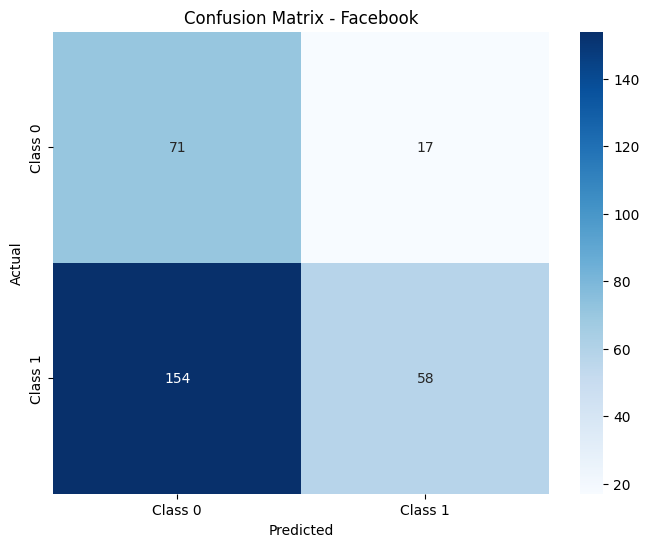

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:38<00:00, 126.47it/s]


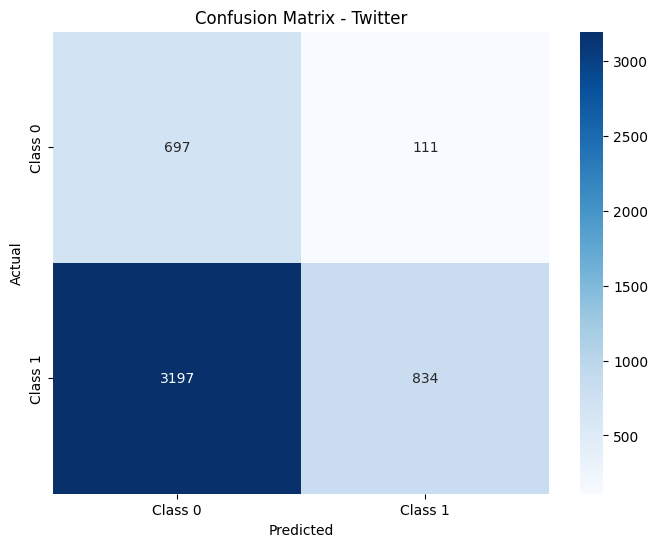

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:04<00:00, 126.33it/s]


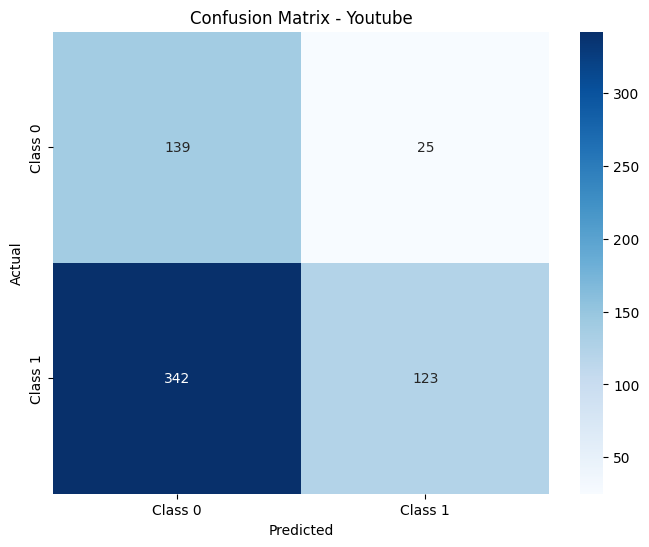

In [3]:
bert_results_reddit = train_and_evaluate("Reddit", ["Facebook", "Twitter", "Youtube"], "bert-base-uncased", BertForSequenceClassification, BertTokenizer, save_path='ml/bert_model')


In [5]:
# Save overall results to CSV
bert_results_rd = pd.DataFrame.from_dict(bert_results_reddit)
bert_results_rd.to_csv('bert_results_reddit.csv', index=True)

Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 1196/1196 [00:53<00:00, 22.48it/s]


Epoch 1/3
Train Loss: 0.0327


Training Epoch 2/3: 100%|██████████| 1196/1196 [00:52<00:00, 22.98it/s]


Epoch 2/3
Train Loss: 0.0150


Training Epoch 3/3: 100%|██████████| 1196/1196 [00:51<00:00, 23.15it/s]


Epoch 3/3
Train Loss: 0.0073


Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 127.68it/s]


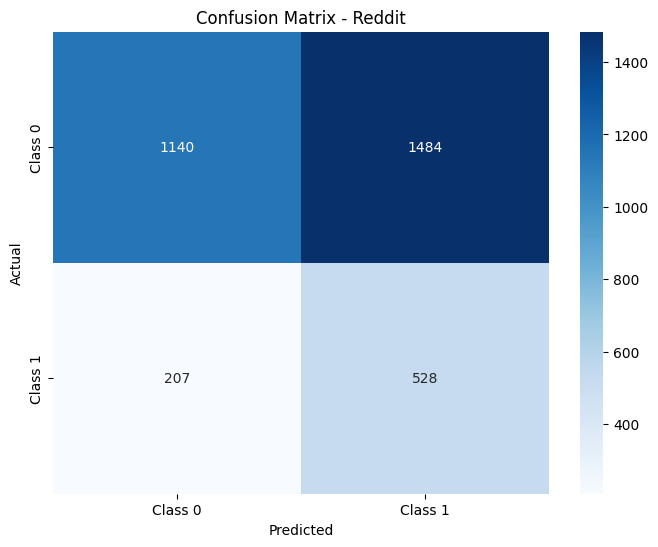

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:37<00:00, 127.44it/s]


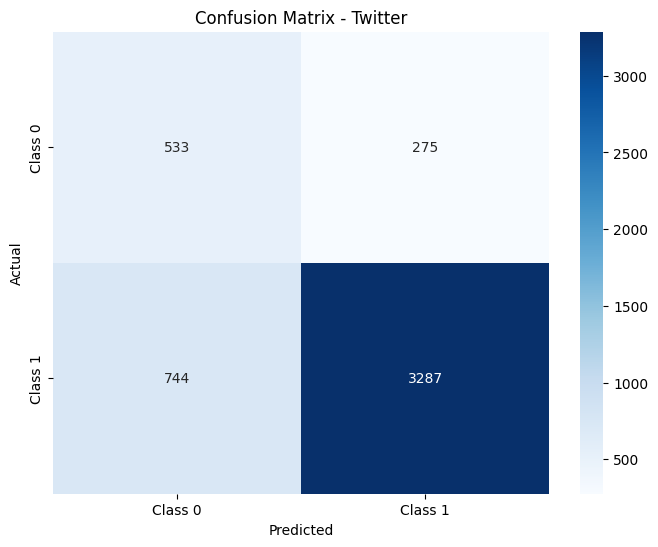

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:04<00:00, 128.35it/s]


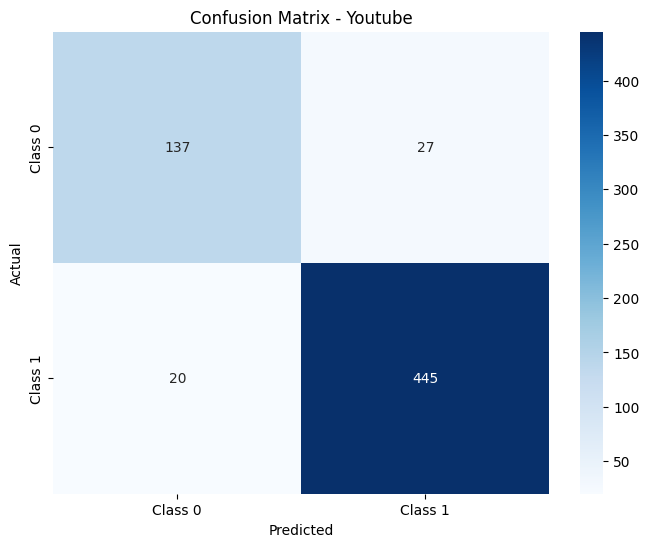

In [6]:
# Train on Facebook and test on other platforms using RoBERTa
roberta_results_facebook = train_and_evaluate("Facebook", ["Reddit", "Twitter", "Youtube"], "roberta-base", RobertaForSequenceClassification, RobertaTokenizer, save_path='ml/roberta_model')

Map:   0%|          | 0/13436 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 13436/13436 [09:42<00:00, 23.07it/s]


Epoch 1/3
Train Loss: 0.0305


Training Epoch 2/3: 100%|██████████| 13436/13436 [09:44<00:00, 22.99it/s]


Epoch 2/3
Train Loss: 0.0259


Training Epoch 3/3: 100%|██████████| 13436/13436 [09:39<00:00, 23.17it/s]


Epoch 3/3
Train Loss: 0.0219


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 111.76it/s]


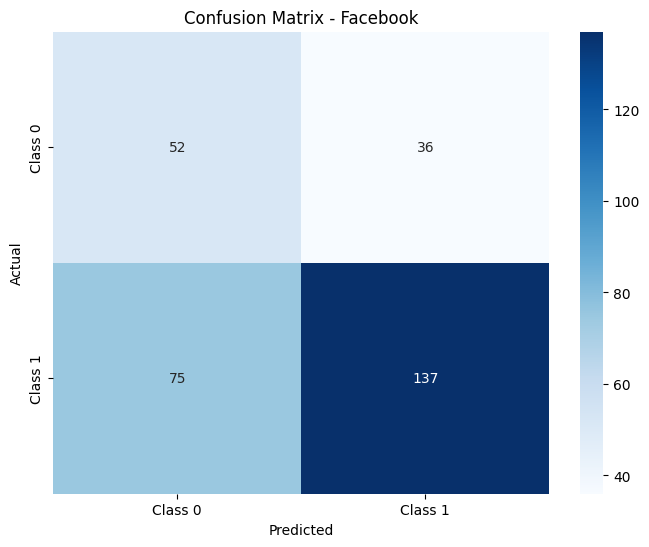

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:38<00:00, 127.14it/s]


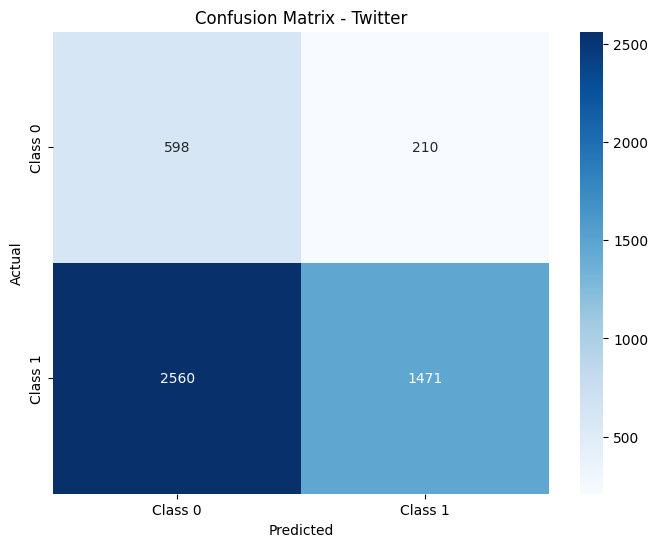

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:04<00:00, 127.14it/s]


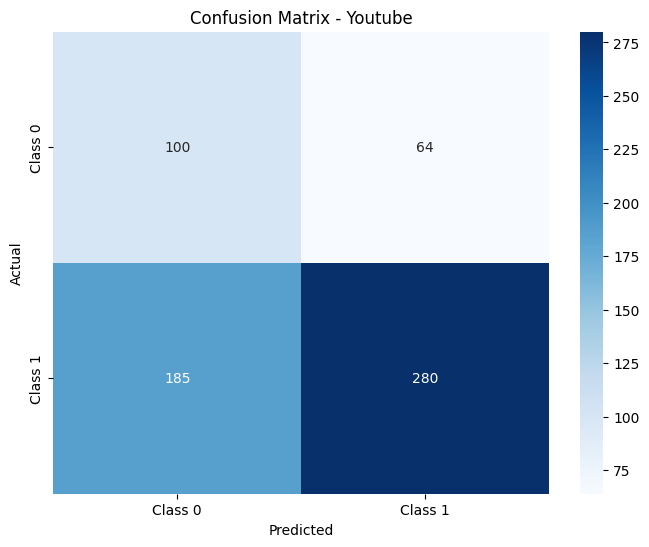

In [11]:
roberta_results_reddit = train_and_evaluate("Reddit", ["Facebook", "Twitter", "Youtube"], "roberta-base", RobertaForSequenceClassification, RobertaTokenizer, save_path='ml/roberta_model')

Map:   0%|          | 0/19356 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 19356/19356 [13:55<00:00, 23.18it/s]


Epoch 1/3
Train Loss: 0.0089


Training Epoch 2/3: 100%|██████████| 19356/19356 [13:18<00:00, 24.25it/s]


Epoch 2/3
Train Loss: 0.0058


Training Epoch 3/3: 100%|██████████| 19356/19356 [11:29<00:00, 28.08it/s]


Epoch 3/3
Train Loss: 0.0046


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 135.12it/s]


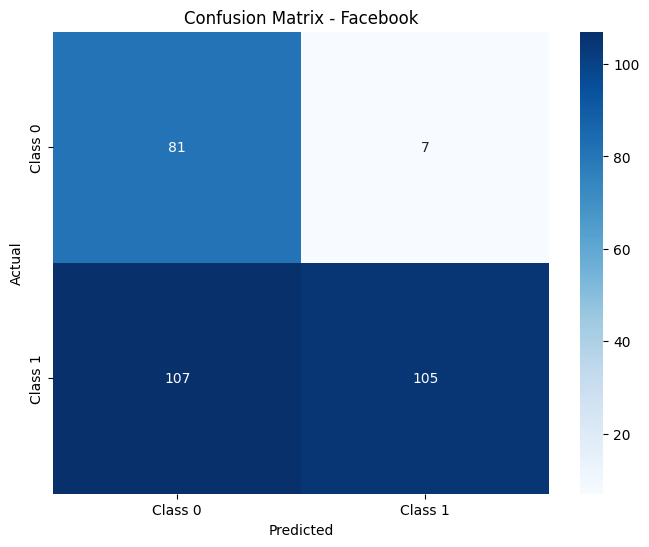

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 127.42it/s]


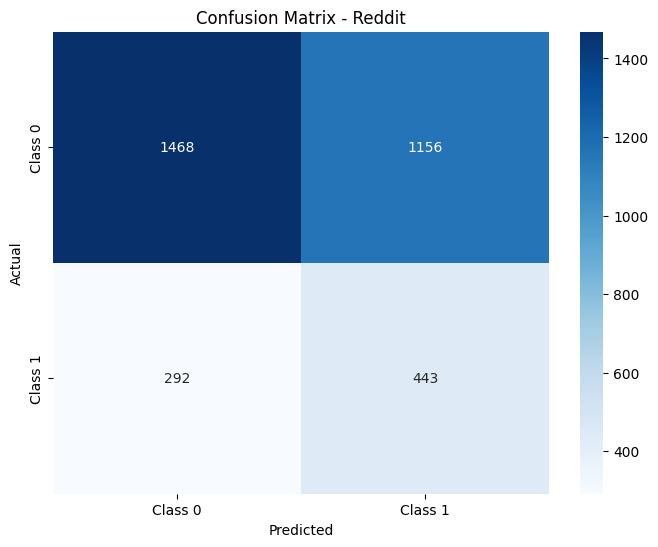

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:04<00:00, 127.45it/s]


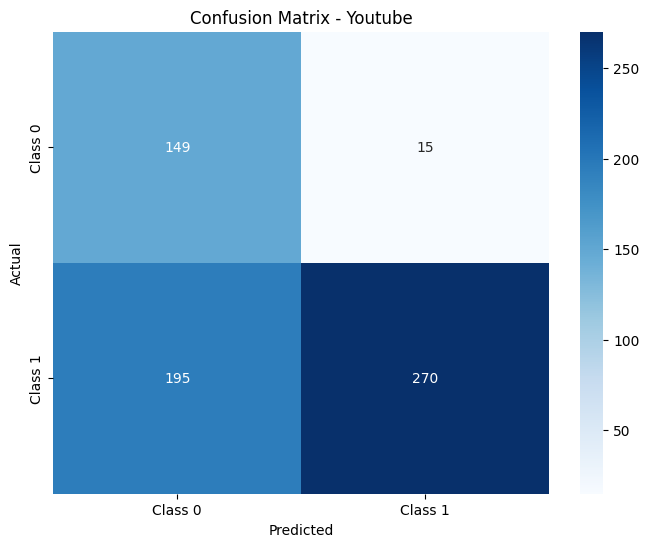

In [13]:
roberta_results_twitter = train_and_evaluate("Twitter", ["Facebook", "Reddit", "Youtube"], "roberta-base", RobertaForSequenceClassification, RobertaTokenizer, save_path='ml/roberta_model')

Map:   0%|          | 0/2512 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 2512/2512 [01:29<00:00, 28.11it/s]


Epoch 1/3
Train Loss: 0.0210


Training Epoch 2/3: 100%|██████████| 2512/2512 [01:29<00:00, 28.16it/s]


Epoch 2/3
Train Loss: 0.0094


Training Epoch 3/3: 100%|██████████| 2512/2512 [01:29<00:00, 28.04it/s]


Epoch 3/3
Train Loss: 0.0042


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 137.95it/s]


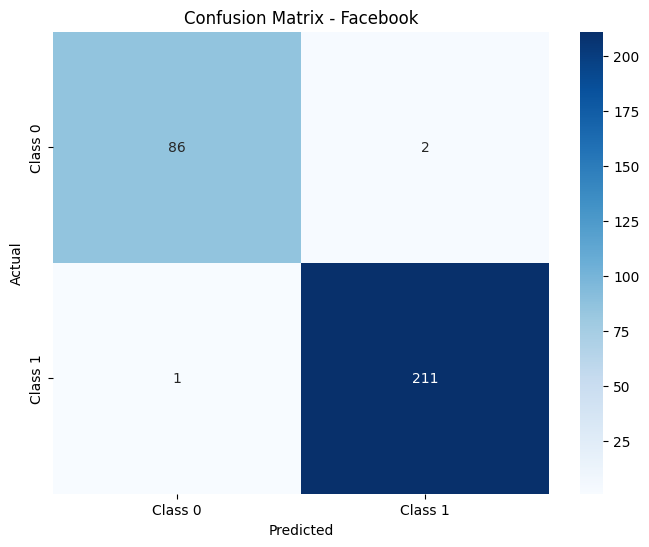

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 127.43it/s]


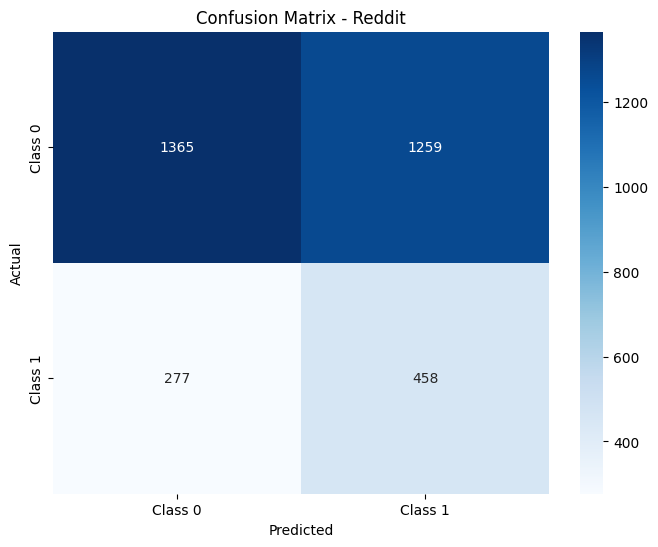

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:37<00:00, 127.50it/s]


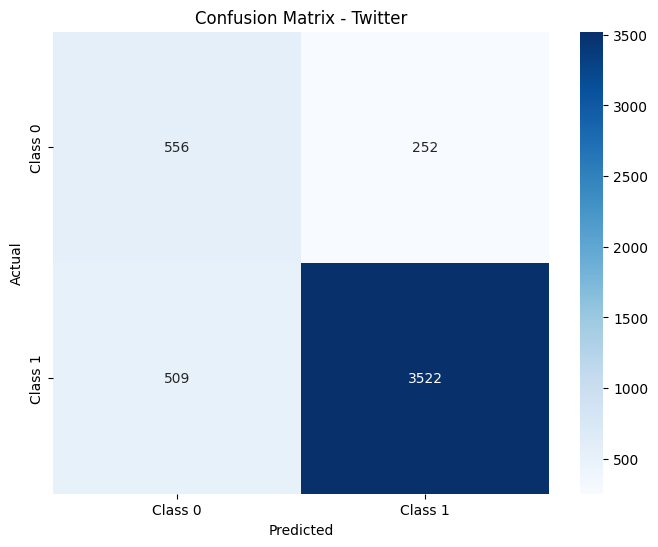

In [15]:
roberta_results_youtube = train_and_evaluate("Youtube", ["Facebook", "Reddit", "Twitter"], "roberta-base", RobertaForSequenceClassification, RobertaTokenizer, save_path='ml/roberta_model')

Map:   0%|          | 0/2512 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 2512/2512 [01:52<00:00, 22.37it/s]


Epoch 1/3
Train Loss: 0.0231


Training Epoch 2/3: 100%|██████████| 2512/2512 [01:50<00:00, 22.83it/s]


Epoch 2/3
Train Loss: 0.0104


Training Epoch 3/3: 100%|██████████| 2512/2512 [01:50<00:00, 22.66it/s]


Epoch 3/3
Train Loss: 0.0055


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 109.78it/s]


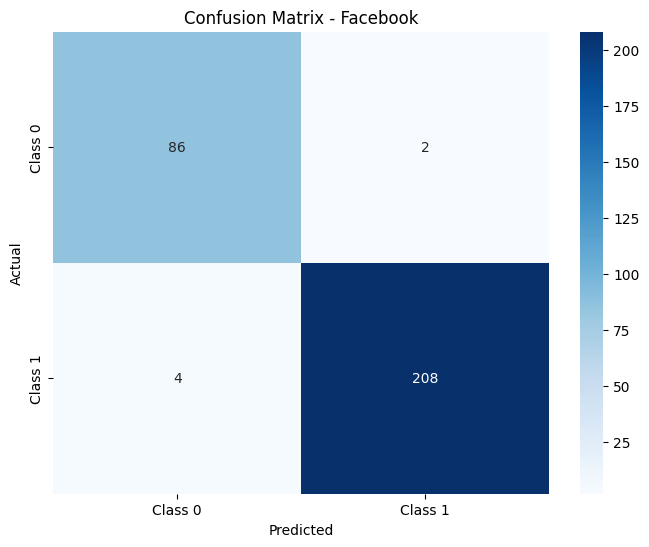

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 126.31it/s]


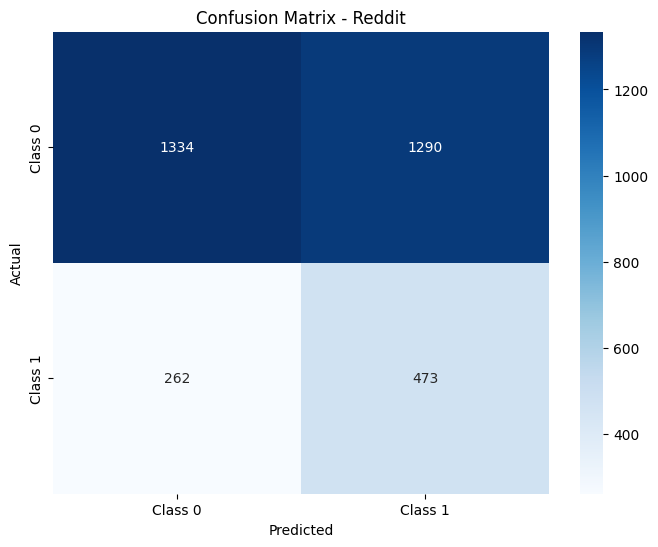

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:37<00:00, 127.65it/s]


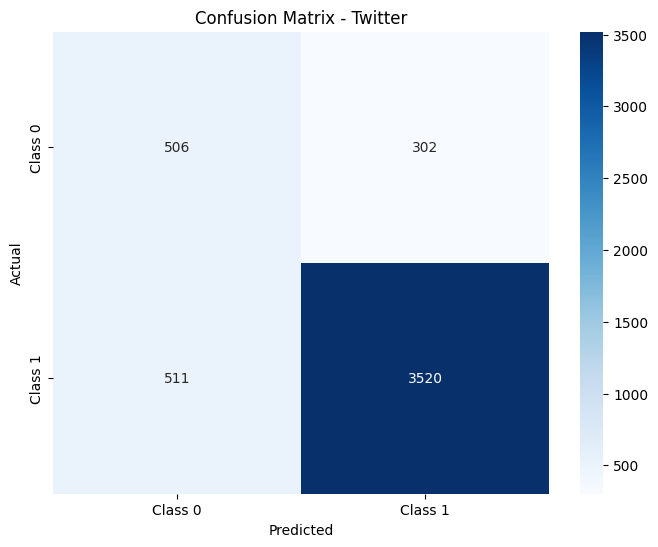

In [3]:
roberta_results_youtube = train_and_evaluate("Youtube", ["Facebook", "Reddit", "Twitter"], "roberta-base", RobertaForSequenceClassification, RobertaTokenizer, save_path='ml/roberta_model')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/home/jovyan/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Map:   0%|          | 0/2512 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 2512/2512 [01:41<00:00, 24.80it/s]


Epoch 1/3
Train Loss: 0.0255


Training Epoch 2/3: 100%|██████████| 2512/2512 [01:28<00:00, 28.53it/s]


Epoch 2/3
Train Loss: 0.0115


Training Epoch 3/3: 100%|██████████| 2512/2512 [01:27<00:00, 28.63it/s]


Epoch 3/3
Train Loss: 0.0058


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 136.93it/s]


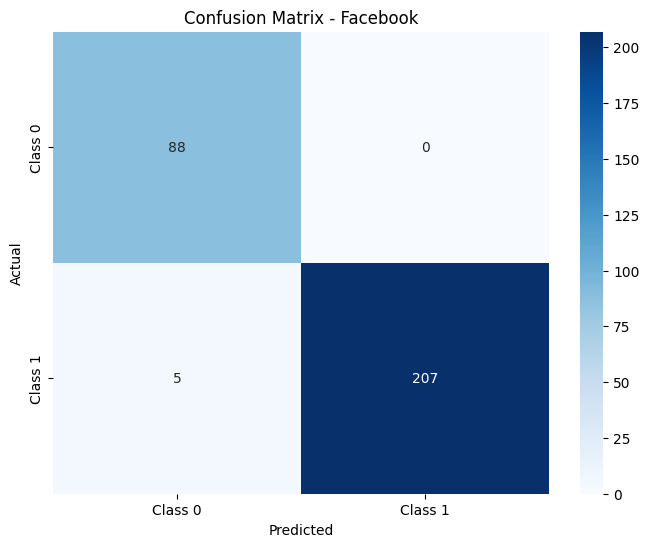

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 124.47it/s]


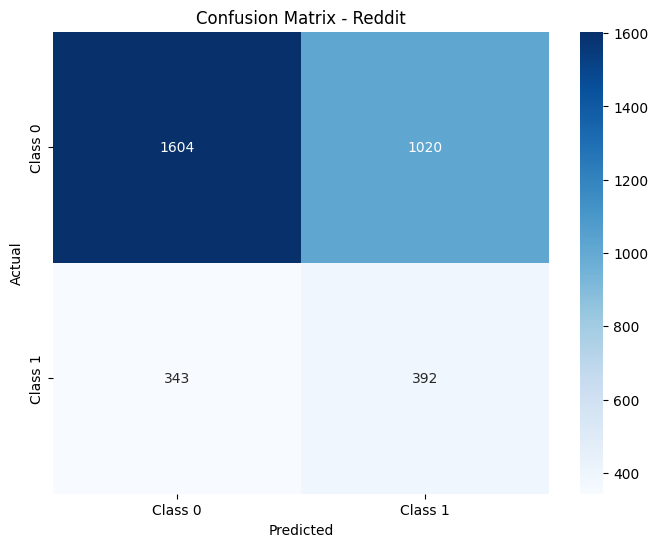

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:38<00:00, 125.27it/s]


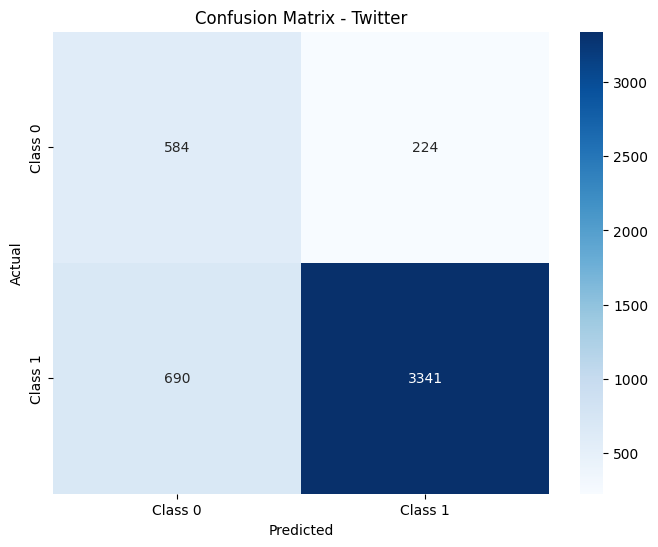

In [4]:
electra_results_youtube = train_and_evaluate("Youtube", ["Facebook", "Reddit", "Twitter"], "google/electra-base-discriminator", ElectraForSequenceClassification, ElectraTokenizer, save_path='ml/electra_model')


Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 1196/1196 [00:43<00:00, 27.68it/s]


Epoch 1/3
Train Loss: 0.0332


Training Epoch 2/3: 100%|██████████| 1196/1196 [00:50<00:00, 23.59it/s]


Epoch 2/3
Train Loss: 0.0161


Training Epoch 3/3: 100%|██████████| 1196/1196 [00:48<00:00, 24.71it/s]


Epoch 3/3
Train Loss: 0.0076


Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:05<00:00, 111.98it/s]


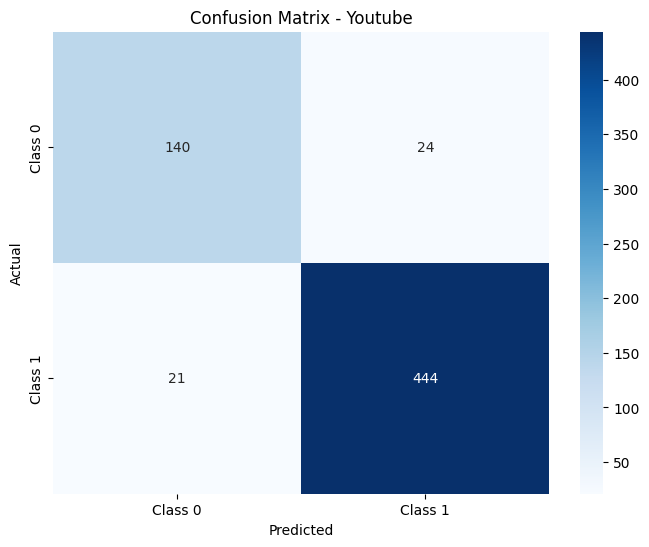

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:27<00:00, 123.55it/s]


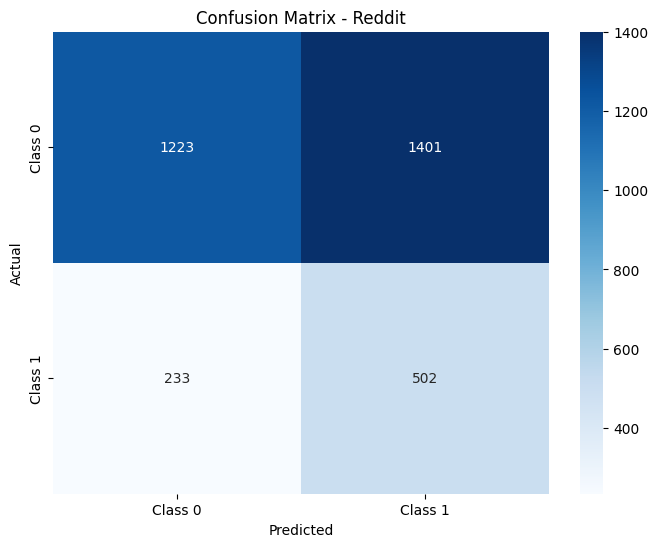

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:39<00:00, 123.10it/s]


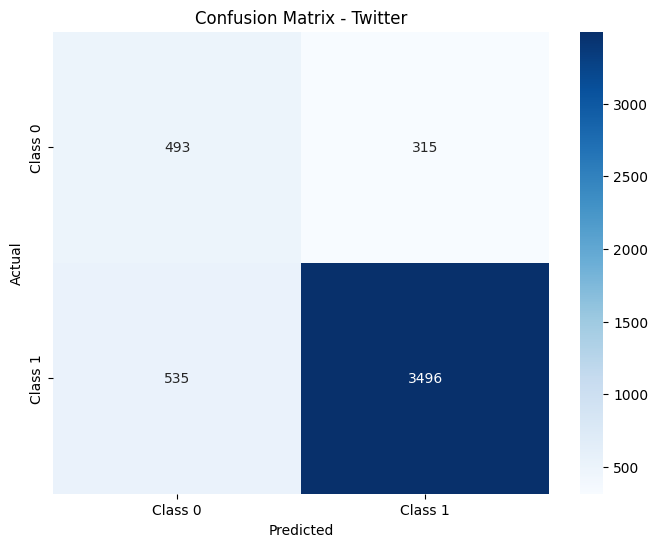

In [6]:
electra_results_facebook = train_and_evaluate("Facebook", ["Youtube", "Reddit", "Twitter"], "google/electra-base-discriminator", ElectraForSequenceClassification, ElectraTokenizer, save_path='ml/electra_model')


Map:   0%|          | 0/13436 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 13436/13436 [08:55<00:00, 25.09it/s]


Epoch 1/3
Train Loss: 0.0304


Training Epoch 2/3: 100%|██████████| 13436/13436 [09:41<00:00, 23.10it/s]


Epoch 2/3
Train Loss: 0.0256


Training Epoch 3/3: 100%|██████████| 13436/13436 [09:59<00:00, 22.42it/s]


Epoch 3/3
Train Loss: 0.0200


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 123.83it/s]


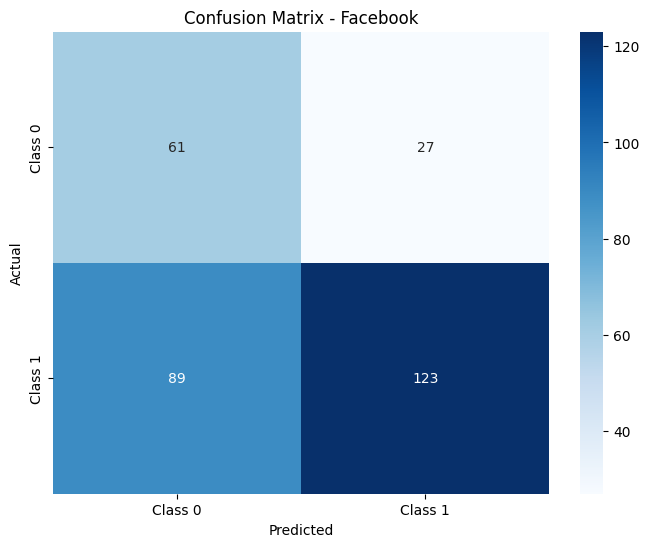

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:05<00:00, 123.56it/s]


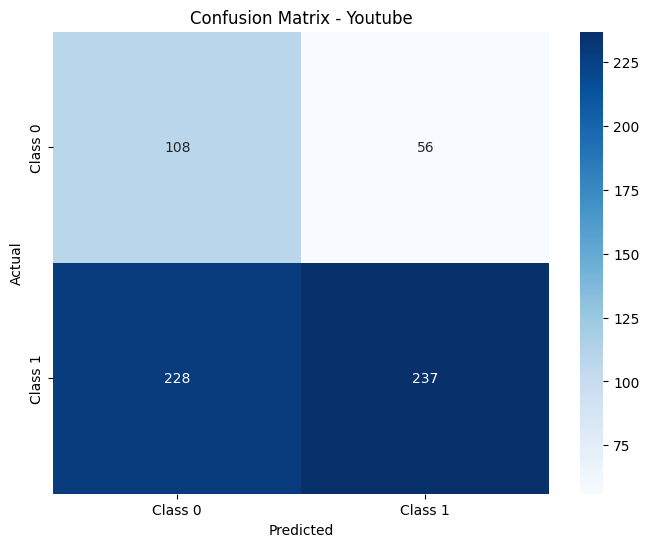

Map:   0%|          | 0/4839 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 4839/4839 [00:38<00:00, 124.10it/s]


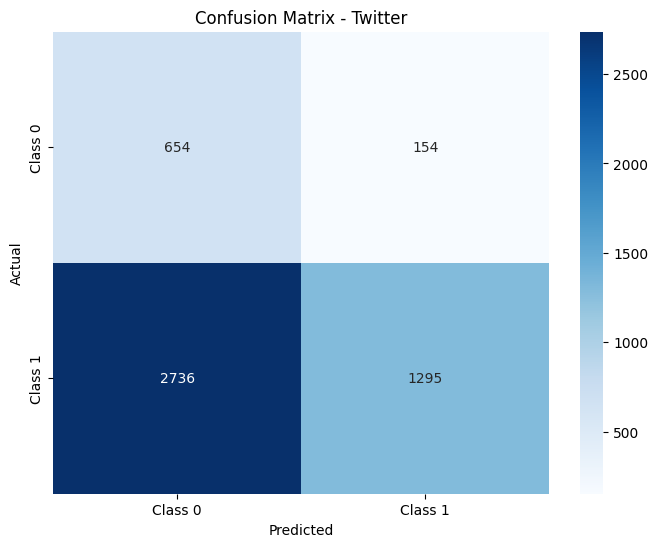

In [7]:
electra_results_reddit = train_and_evaluate("Reddit", ["Facebook", "Youtube", "Twitter"], "google/electra-base-discriminator", ElectraForSequenceClassification, ElectraTokenizer, save_path='ml/electra_model')


Map:   0%|          | 0/19356 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/3: 100%|██████████| 19356/19356 [14:44<00:00, 21.88it/s]


Epoch 1/3
Train Loss: 0.0091


Training Epoch 2/3: 100%|██████████| 19356/19356 [14:01<00:00, 23.01it/s]


Epoch 2/3
Train Loss: 0.0058


Training Epoch 3/3: 100%|██████████| 19356/19356 [13:57<00:00, 23.12it/s]


Epoch 3/3
Train Loss: 0.0046


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 300/300 [00:02<00:00, 106.71it/s]


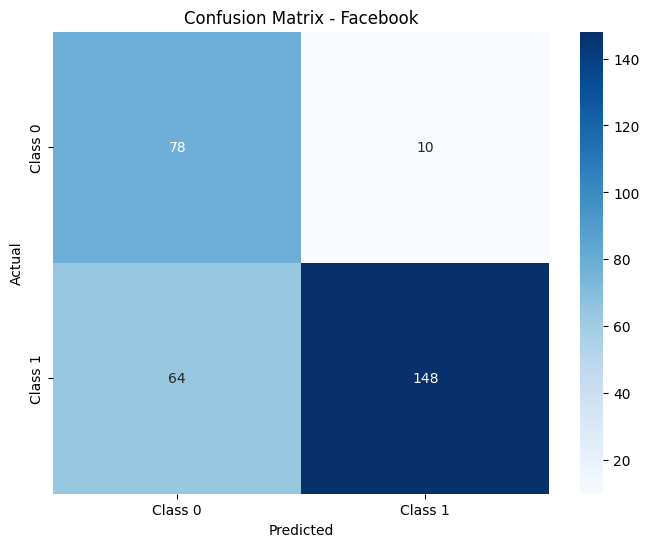

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 3359/3359 [00:26<00:00, 126.12it/s]


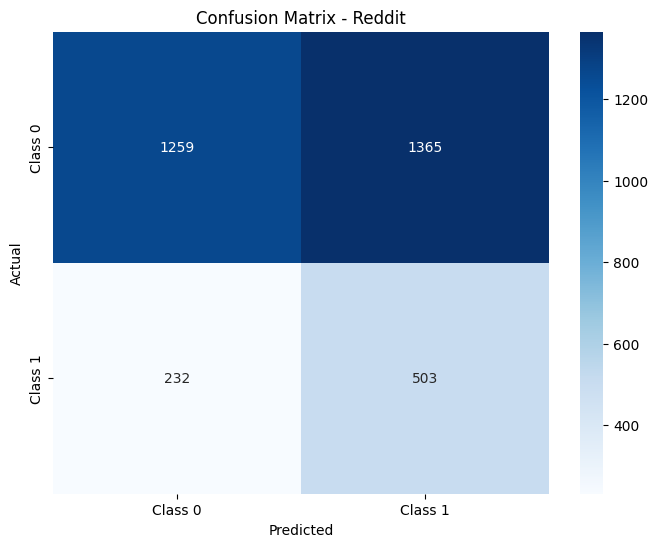

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 629/629 [00:04<00:00, 126.27it/s]


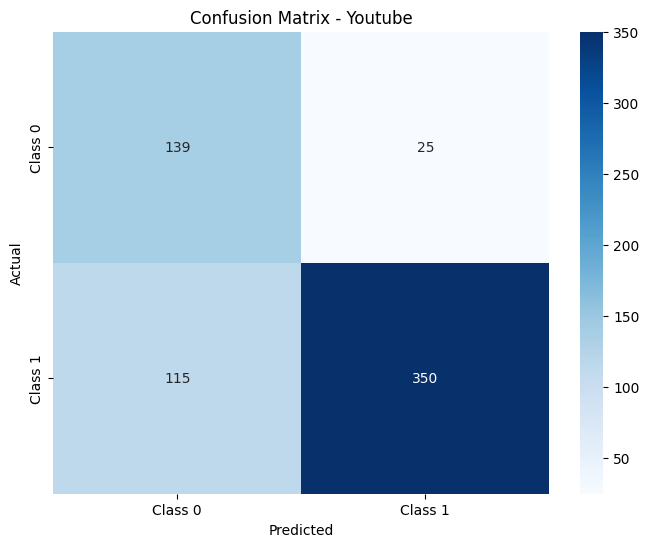

In [8]:
electra_results_twitter = train_and_evaluate("Twitter", ["Facebook", "Reddit", "Youtube"], "google/electra-base-discriminator", ElectraForSequenceClassification, ElectraTokenizer, save_path='ml/electra_model')


In [10]:
# Save overall results to CSV
bert_results_rd = pd.DataFrame.from_dict(bert_results_reddit)
bert_results_rd.to_csv('bert_results_reddit.csv', index=True)

In [12]:
# Save overall results to CSV
roberta_results_rd = pd.DataFrame.from_dict(roberta_results_reddit)
roberta_results_rd.to_csv('roberta_results_reddit.csv', index=True)

In [14]:
# Save overall results to CSV
roberta_results_tw = pd.DataFrame.from_dict(roberta_results_twitter)
roberta_results_tw.to_csv('roberta_results_twitter.csv', index=True)

In [16]:
# Save overall results to CSV
roberta_results_yt = pd.DataFrame.from_dict(roberta_results_youtube)
roberta_results_yt.to_csv('roberta_results_youtube.csv', index=True)

In [5]:
# Save overall results to CSV
electra_results_yt = pd.DataFrame.from_dict(electra_results_youtube)
electra_results_yt.to_csv('electra_results_youtube.csv', index=True)


In [9]:
# Save overall results to CSV
electra_results_rd = pd.DataFrame.from_dict(electra_results_reddit)
electra_results_rd.to_csv('electra_results_reddit.csv', index=True)


In [10]:
# Save overall results to CSV
electra_results_fb = pd.DataFrame.from_dict(electra_results_facebook)
electra_results_fb.to_csv('electra_results_facebook.csv', index=True)


In [11]:
# Save overall results to CSV
electra_results_tw = pd.DataFrame.from_dict(electra_results_twitter)
electra_results_tw.to_csv('electra_results_twitter.csv', index=True)
